In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pyopencl as cl
import pyopencl.array as cl_array
import time
# import asyncio
# import websockets
# import pandas as pd
import matplotlib.ticker as ticker


%load_ext pyopencl.ipython_ext
%matplotlib inline  

In [2]:
platform = cl.get_platforms()[0]
# print(cl.get_platforms())
dev = platform.get_devices()[0]
print(platform.get_devices()[0].name)
print("Device max clock speed:", dev.max_clock_frequency, 'MHz')
print("Device max work items:", dev.get_info(cl.device_info.MAX_WORK_ITEM_SIZES))
# print('Max work item dims:', str(dev.max_work_item_dimensions))
# print('Max work group size:', str(dev.max_work_group_size))
print('Memory (global):', dev.global_mem_size//1024//1024, 'MB')
print('Memory (local):', dev.local_mem_size//1024, 'KB')
print('Max compute units:', dev.max_compute_units)

ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

Intel(R) Iris(TM) Plus Graphics 640
Device max clock speed: 1100 MHz
Device max work items: [256, 256, 256]
Memory (global): 1488 MB
Memory (local): 64 KB
Max compute units: 48


In [3]:
%%cl_kernel -o "-cl-fast-relaxed-math"

__kernel void nbody_simple(
    __global float4* pos, 
    __global float4* vel,
    __global float4* pos_new, 
    __global float4* vel_new)
{
    const float STEP =  0.00027397260273972603; // 1/365/10
    const float EPS = 0.000001;
    const float G = 0.03765; //6.67300E-11; 

    const float4 step = (float4)(STEP, STEP, STEP, 0.0f);

    // id of this thread
    int gti = get_global_id(0);

    // total number of particles
    int n = get_global_size(0);

    float4 p = pos[gti];
    float4 v = vel[gti];
    //float4 v = vel[gti];

    float4 a = (float4)(0.0f, 0.0f, 0.0f, 0.0f);


    for (int j = 0; j<n; j++) 
    {
        if (j == gti)
            continue;
        float4 pj = pos[j]; // Read a cached particle position 
        float4 diff = pj - p; // ignoring mass
        float invr_distance = rsqrt(diff.x*diff.x + diff.y*diff.y + diff.z*diff.z + EPS); // 1/sqrt
        a += pj.w * diff * invr_distance * invr_distance * invr_distance;
    }

    a *= G;

    // update in global memory
    pos_new[gti] = p+step * v + 0.5f * step * step * a;
    vel_new[gti] = v + step * a;
}

c:\program files (x86)\python36-32\lib\site-packages\pyopencl\cffi_cl.py:1521: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


In [8]:
# load data
pos_host, vel_host = load_2048(2)

# allocate and init memory on device
pos_dev = cl_array.to_device(queue, pos_host)
vel_dev = cl_array.to_device(queue, vel_host)
pos_new_dev = cl_array.empty_like(pos_dev)
vel_new_dev = cl_array.empty_like(vel_dev)

print(pos_host.shape)

(2, 4)


In [7]:
%%time
# loop over 365 days
for i in range(3650):
    # execute kernal
    nbody_simple(queue, (pos_host.shape[0],), None,
                 pos_dev.data, vel_dev.data, 
                 pos_new_dev.data, vel_new_dev.data)
    # copy new position to host
    pos_host = pos_new_dev.get()
    # copy new position and velocity into old arrays on device 
    cl.enqueue_copy(queue, pos_dev.data, pos_new_dev.data)
    cl.enqueue_copy(queue, vel_dev.data, vel_new_dev.data)

Wall time: 1.34 s


In [31]:
bodies = np.genfromtxt('omp.csv', delimiter=',', dtype=np.float32)

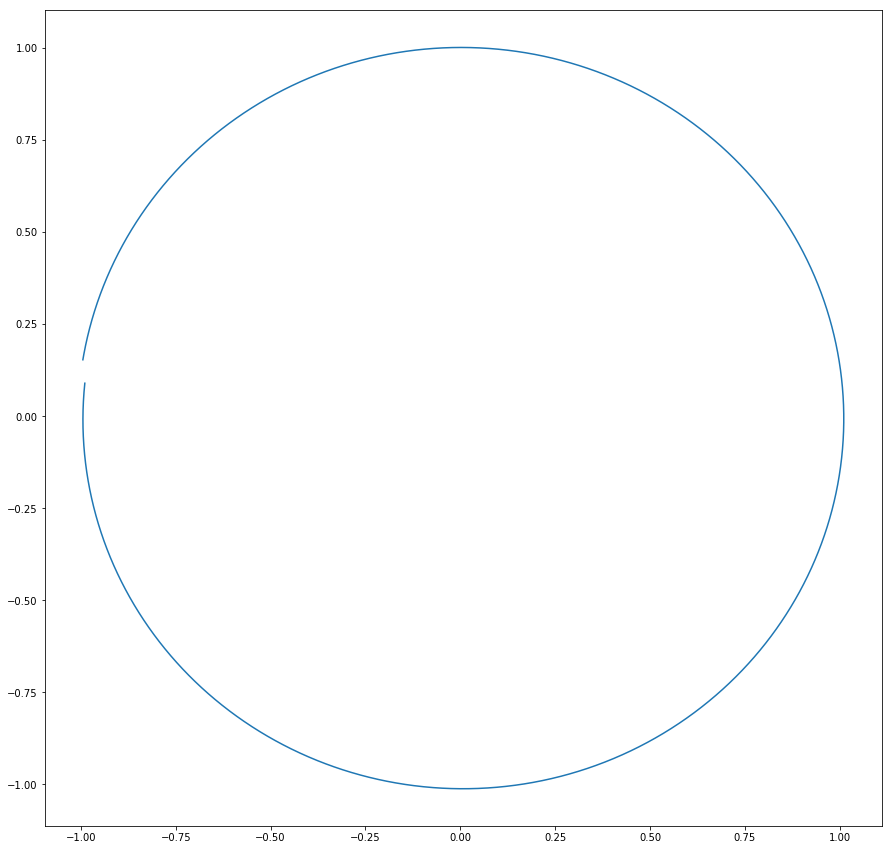

In [32]:
fig = plt.figure(figsize=(15,15))
plt.plot(bodies[:,9],bodies[:,10], marker='')
# plt.plot(tmp[:,3*3],tmp[:,4*3], marker='o')


# ax = fig.gca(projection='3d')
# axes = plt.gca()
# axes.set_xlim([-500,6500])
# axes.set_ylim([-6000,1000])
# for b in bodies[:]:
#     plt.plot(b[:,0],b[:,1], marker='o')
#     plt.plot(sun[:,0],sun[:,1], marker='*')

# print(earth)
# b = data.iloc[0,:].values.reshape((340, 3))
# plt.scatter(b[:,0],b[:,1], marker='o')
